# Interaction Estimates
In this notebook we estimate the interaction strength uisng pairwise growth experiments


# Calculating

In [1]:
library(tidyverse)
library(broom)
library(nls.multstart)
library(cowplot)
library(gridExtra)
library(lme4)
library(lmerTest)
library(MuMIn)
library(minpack.lm)

── Attaching packages ────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.6     ✔ dplyr   1.0.7
✔ tidyr   1.1.4     ✔ stringr 1.4.0
✔ readr   2.1.1     ✔ forcats 0.5.1

── Conflicts ───────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine


Loading required package: Matrix


Attaching package: ‘Matrix’


The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack



Attaching package: ‘lmerTest’


The following object is masked from ‘package:lme4’:

    lmer


The following object is masked from ‘package:stats’:

    step




# Fit Growth Curves

### Read Data

In [2]:
set.seed(1)

#read data in
grw_df <- read_csv(file= "../data/interactions/Pairwise_M9_Experiment.csv",col_type = cols()) %>%
    pivot_longer(-Reading,names_to = "ID", values_to = "OD") %>%
    separate(ID,into = c("ID","Treatment","Replicate"),sep = "_")

## correct data using average blank
Blank <- mean(grw_df$OD[which(grw_df$Treatment == "Blank")])
grw_df$OD_corrected <- grw_df$OD - Blank
grw_df <- grw_df[-which(grw_df$Treatment == "Blank"),]

## rename columns
names(grw_df) <- c("Time","Id", "Treatment", "Replicate", "OD","ODc")
#set negative values to 0
grw_df$ODc[which(grw_df$ODc<0)] <- 0

In [3]:
grw_df

Time,Id,Treatment,Replicate,OD,ODc
<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>
0,2/15,NE,R1,0.0903,0.0016405637
0,2/15,NE,R2,0.0898,0.0011405637
0,2/15,NE,R3,0.0893,0.0006405637
0,2/15,NE,R4,0.0908,0.0021405637
0,2/15,NE,R5,0.0912,0.0025405637
0,2/15,NE,R6,0.0908,0.0021405637
0,2/15,E,R1,0.0947,0.0060405637
0,2/15,E,R2,0.0945,0.0058405637
0,2/15,E,R3,0.0949,0.0062405637


### Remove outliers

In [3]:
## load outliers dataframe
Out <- read.table("../data//interactions//all_outliers.csv", header = TRUE, sep = ",")

#generate_outliers code
code_out <- paste(Out$t,Out$pa,sep="-") %>%
    str_replace_all(., regex("[:-]"),"_") %>%
    str_replace_all(., fixed("."), "/")

grw_df <- grw_df %>% 
    mutate(code = paste(Time,Id,Treatment,Replicate, sep = "_")) %>%
    mutate(outlier = code %in% code_out)

grw_df$ODc[which(grw_df$Id == "15.18_NE" & grw_df$Time > 24)] <- NA
grw_df$ODc[which(grw_df$Id == "18_NE" & grw_df$Time > 32)] <- NA
grw_df$ODc[which(grw_df$Id == "20_E" & grw_df$Time > 38)] <- NA
grw_df$ODc[which(grw_df$Id == "20_NE" & grw_df$Time > 24)] <- NA
grw_df$ODc[which(grw_df$Id == "20.23_E" & grw_df$Time > 48)] <- NA
grw_df$ODc[which(grw_df$Id == "20_E" & grw_df$Replicate == "R2")] <- NA
grw_df$ODc[which(grw_df$Id == "20_E" & grw_df$Replicate == "R3")] <- NA
grw_df$ODc[which(grw_df$Id == "20_E" & grw_df$Replicate == "R5" & grw_df$Time < 17)] <- NA

In [4]:
#remove outliers and add id column
grw_df <- grw_df %>%
    filter(!outlier) %>%
    mutate(curve_Id = paste(Id,Treatment,Replicate, sep = "_"),
          ODc_log10 = log10(ODc)) %>%
    as.data.frame()

### Fit growth models

In [5]:
## Fit growth models 
logistic <- function(r,K,t,N0){
    K / (1 + ( (K-N0)/N0) * exp(-r*t))
}

exponential <- function(r,t,N0){
    N0 * exp(r*t)
}

#fit with NLS
start_up_bounds_log <- c(r = 2,   K = 4, N0 = 0.006)
start_low_bounds_log  <- c(r = 0.1, K = 0, N0 = 0.001)
low_log  <- c(r = 0.1, K = 0, N0 = 0.0)
up_log  <- c(r = 4, K = 1, N0 = 0.1)

start_up_bounds_exp <- c(r = 2, N0 = 0.006)
start_low_bounds_exp  <- c(r = 0.1, N0 = 0.001)
low_exp  <- c(r = 0.1, N0 = 0.0)
up_exp  <- c(r = 4, N0 = 0.1)

#Fit to early timeframe
model_fits <- grw_df %>%
    filter(Time < 20) %>%
    group_by(Id,Treatment,Replicate) %>%
    mutate(n = n()) %>%
    filter(n > 3) %>%
    nest() %>%
    mutate(logistic_fit = purrr::map(data, ~ nls_multstart(ODc ~ logistic(r,K, N0,t = Time),
                                    data = .x, iter = 500,
                                    start_lower = start_low_bounds_log, start_upper = start_up_bounds_log,
                                    supp_errors = "Y", na.action = na.omit,
                                    lower = low_log, upper = up_log)),
           
          exponential_fit = purrr::map(data, ~ nls_multstart(ODc ~ exponential(r,N0,t = Time),
                                    data = .x, iter = 500,
                                    start_lower = start_low_bounds_exp, start_upper = start_up_bounds_exp,
                                    supp_errors = "Y", na.action = na.omit,
                                    lower = low_exp, upper = up_exp)))

In [6]:
#select best fit with AIC
model_fits_2 <- model_fits %>%
    select(-data) %>%
    mutate(log_AIC = map(logistic_fit, AIC), exp_AIC = map(exponential_fit, AIC)) %>%
    unnest(cols = c(log_AIC,exp_AIC)) %>%
    mutate(fit = ifelse(log_AIC < exp_AIC, logistic_fit, exponential_fit),
          model = ifelse(log_AIC < exp_AIC, "Logistic", "Exponential"))
#get parameters
params_log <- model_fits_2 %>%
    mutate(params = map(fit,tidy)) %>%
    unnest(params) %>%
    select(Id, Treatment, Replicate, term, estimate, std.error, p.value, model) %>%
    filter(term == "r")

In [7]:
#get pairwise and monculture growth rates
df_pair <- params_log %>%
    filter(str_detect(Id, fixed("/"))) %>%
    separate(Id, into = c("OTU_1","OTU_2"),sep = "/", remove = F)

df_sp <- params_log %>%
    filter(!str_detect(Id, fixed("/")))

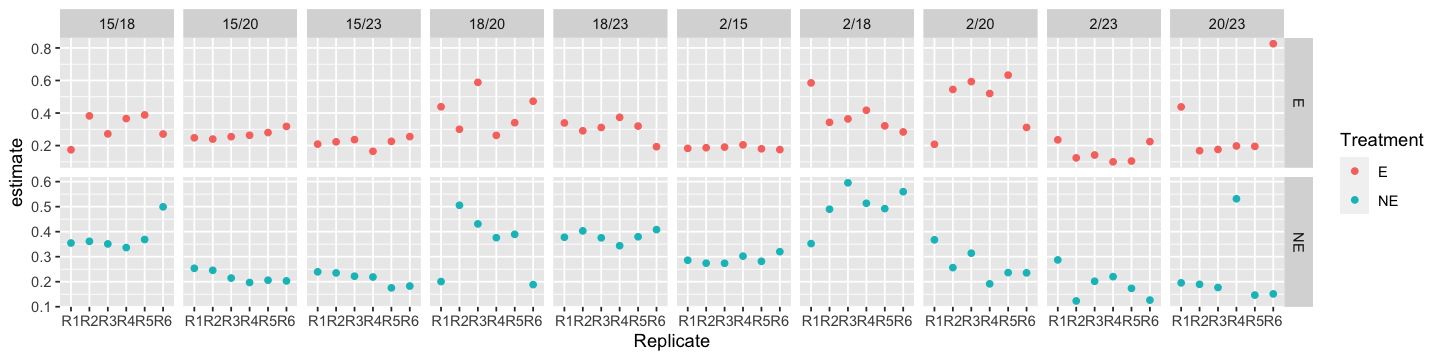

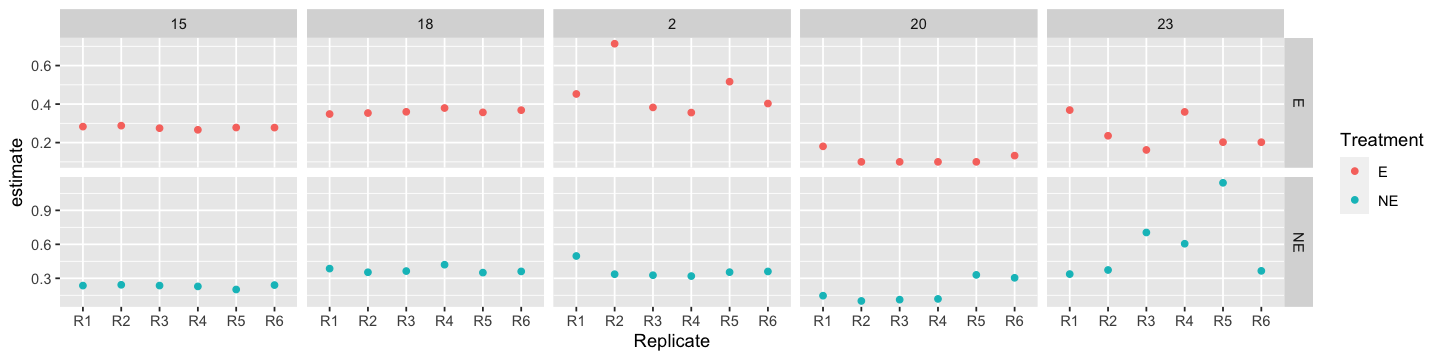

In [8]:
options(repr.plot.width = 12, repr.plot.height = 3)
#PLot growth estimates
df_pair %>%
    ggplot(aes(x=Replicate,y=estimate, color = Treatment))+
        geom_point()+
        facet_grid(Treatment ~ Id, scales = "free") 

df_sp %>%
    ggplot(aes(x=Replicate,y=estimate, color = Treatment))+
        geom_point()+
        facet_grid(Treatment ~ Id, scales = "free")

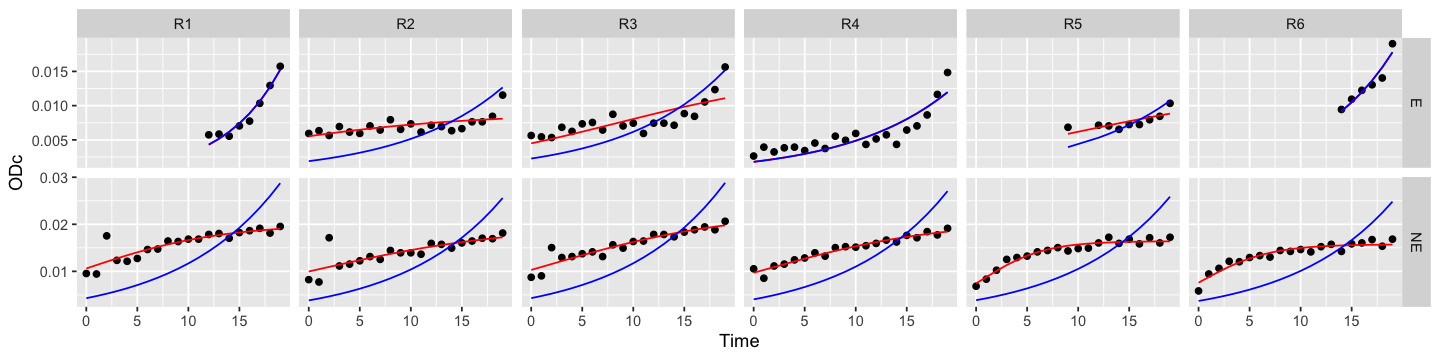

In [9]:
#For plotting growth curve estimates
model_fits %>%
    filter(Id == "20") %>%
    mutate(log_pred = map(logistic_fit,predict),
           exp_pred = map(exponential_fit,predict)) %>%
    select(-logistic_fit,-exponential_fit) %>%
    unnest(cols = c(data, log_pred, exp_pred)) %>%
    ggplot(aes(x=Time, y = ODc)) +
            geom_point()+
            geom_line(aes(y = log_pred), color = "red") + 
            geom_line(aes(y = exp_pred), color = "blue") + 
            facet_grid(Treatment ~ Replicate, scales = "free")

### Bootstrapping Interaction Estimates

In [10]:
set.seed(1)

#estimat with bootstrapping
itt <- expand_grid(pair = unique(df_pair$Id), Treatment = unique(df_pair$Treatment)) %>%
    separate(pair, c("OTU_1","OTU_2"), remove = F)

N <- 10000
a_est <- list()

#loop over estimates
for(i in 1:nrow(itt)){
    #get pairs
    OTU1 <- itt$OTU_1[i]
    OTU2 <- itt$OTU_2[i]

    #setup results
    df <- tibble(rep = 1:N, OTU_1 = OTU1, OTU_2 = OTU2,pairs = paste(OTU_1,OTU_2), Treatment = itt$Treatment[i])
    #get individual params
    params_1 <- df_sp %>%
        filter(Id == OTU1, Treatment == itt$Treatment[i])
    params_2 <- df_sp %>%
        filter(Id == OTU2, Treatment == itt$Treatment[i])
    
    #get pairwise params
    params_12 <- df_pair %>%
        filter(OTU_1 == OTU1, OTU_2 == OTU2, Treatment == itt$Treatment[i])

    r1 <- sample(params_1$estimate, N, replace = T, prob = 1 / params_1$p.value)
    r2 <- sample(params_2$estimate, N, replace = T, prob = 1 / params_2$p.value)
    
    t_ind <- sample(1:nrow(params_12), N, replace = T, prob = 1 / params_12$p.value )
    rt <- params_12$estimate[t_ind]
    # C0 <- params_12$C0[t_ind]
    
    df$a <- (2*rt - r1 - r2)
    
    a_est[[i]] <- df
}

feas_df <- bind_rows(a_est) 
    

In [11]:
df_order <- feas_df %>%
    group_by(OTU_1,OTU_2,Treatment) %>%
    summarise(mean = mean(a), Q2.5 = quantile(a,0.05),Q97.5 = quantile(a,0.95)) %>%
    pivot_wider(names_from = Treatment, values_from = c(mean,Q2.5,Q97.5)) %>%
    mutate(mean = mean_NE - mean_E, Q2.5 = Q2.5_NE - Q97.5_E, Q97.5 = Q97.5_NE - Q2.5_E) %>%
    select(OTU_1,OTU_2,mean) %>%
    arrange(mean) %>%
    mutate(pairs = paste(OTU_1,OTU_2,sep = " "))

levels <- rev(df_order$pairs)
levels

`summarise()` has grouped output by 'OTU_1', 'OTU_2'. You can override using the `.groups` argument.



[1] "2 18"  "15 18" "2 15"  "18 23" "15 23" "2 23"  "15 20" "18 20" "20 23"
[10] "2 20"

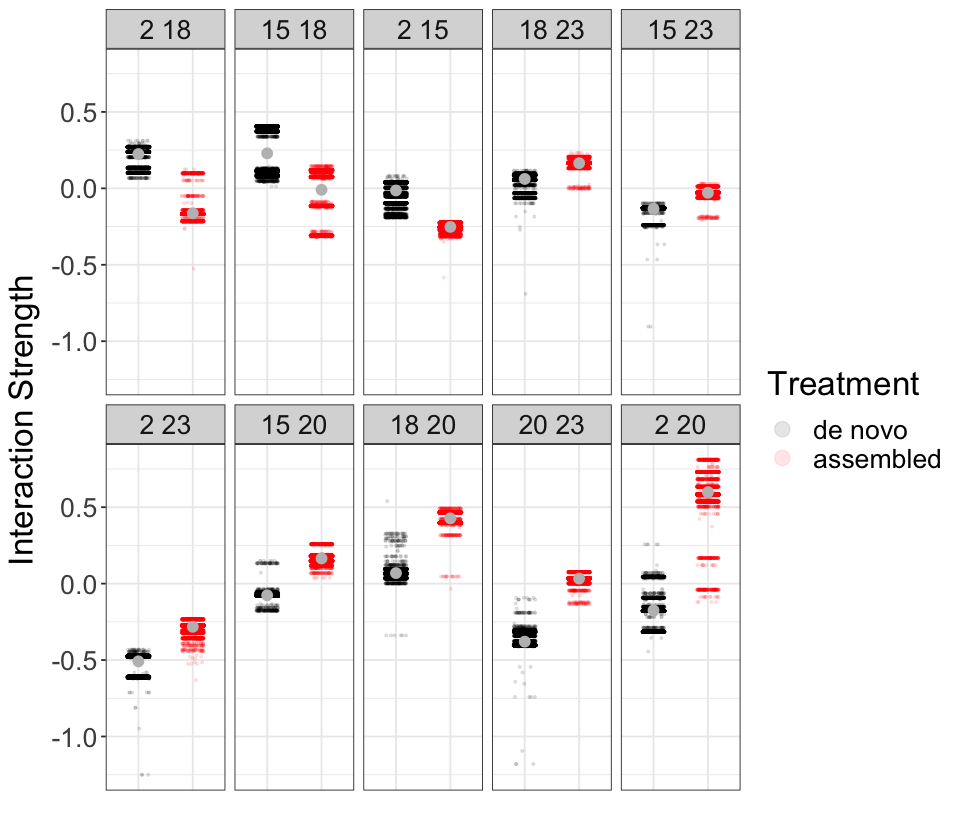

In [12]:
options(repr.plot.width = 8, repr.plot.height = 7)

#plot estimates
p1 <- feas_df %>%    
    mutate(pairs = factor(pairs, levels = levels)) %>%
    mutate(Treatment = case_when(Treatment =="E" ~ "assembled", Treatment == "NE" ~ "de novo")) %>%
    ggplot(aes(x=rev(Treatment), y=a, colour = Treatment))+
        geom_point(size = 0.5, alpha = 0.1, position = position_jitter(width = 0.2))+
        stat_summary(fun = mean, color = "grey") +
        facet_wrap(~pairs,nrow = 2)+
        ylab("Interaction Strength") +
        xlab("")+
        theme_bw()+
        scale_color_manual(values = c("de novo"="Black", "assembled"="Red"))+
        theme(text = element_text(size = 20), axis.text.x = element_blank(), axis.ticks.x = element_blank())+
        guides(color = guide_legend(override.aes = list(size = 4)))

suppressWarnings(ggsave("../plots/FigS2_interactions_new.pdf", p1, height = 7, width = 8))
suppressWarnings(plot(p1))

`summarise()` has grouped output by 'OTU_1', 'OTU_2'. You can override using the `.groups` argument.



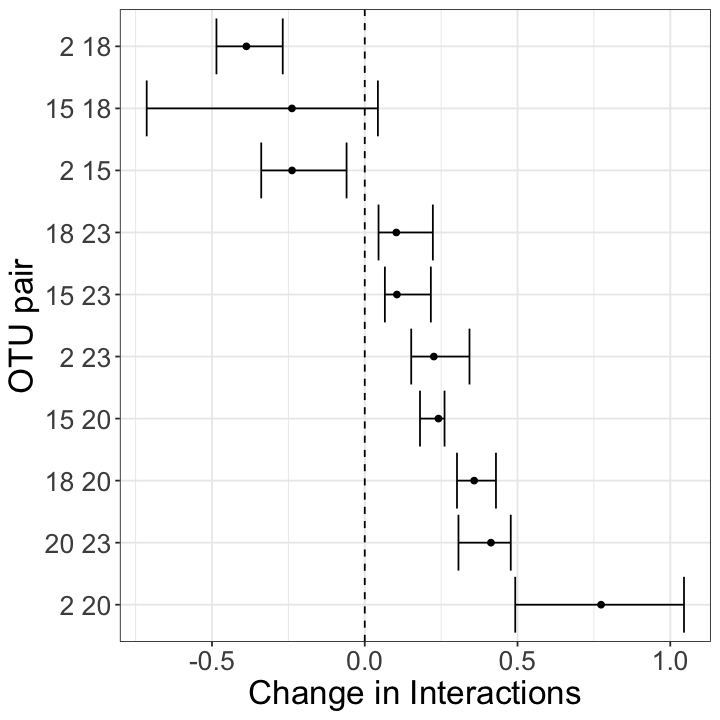

In [16]:
options(repr.plot.width = 6, repr.plot.height = 6)

p2 <- feas_df %>%
    group_by(OTU_1,OTU_2,Treatment) %>%
    summarise(mean = mean(a), Q2.5 = quantile(a,0.05),Q97.5 = quantile(a,0.95)) %>%
    pivot_wider(names_from = Treatment, values_from = c(mean,Q2.5,Q97.5)) %>%
    mutate(mean = mean_NE - mean_E, Q2.5 = Q2.5_NE - Q97.5_E, Q97.5 = Q97.5_NE - Q2.5_E, ) %>%
    ggplot(aes(y = fct_reorder(paste(OTU_1,OTU_2),mean), x = -mean))+
        geom_point()+
        geom_errorbarh(aes(xmin = -Q2.5, xmax = -Q97.5))+
        geom_vline(xintercept = 0.0,linetype = 2) + 
        xlab("Change in Interactions") + ylab("OTU pair") +
        theme_bw()+
        theme(text = element_text(size = 20)) 
    

p2

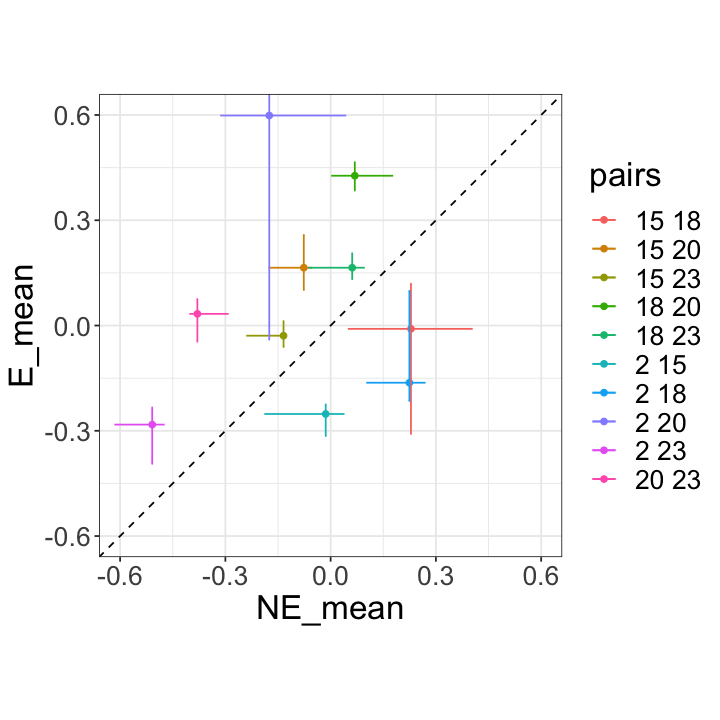

In [61]:
q1 <- function(x){quantile(x,0.01)}
q2 <- function(x){quantile(x,0.99)}

feas_df %>%
    pivot_wider(names_from = Treatment, values_from = a) %>%
    group_by(pairs) %>%
    summarise_at(c("NE","E"), list(mean = mean,lb = q1,ub = q2), ) %>%
    ggplot(aes(x = NE_mean, y = E_mean, color = pairs))+
        geom_point()+
        geom_errorbar(aes(xmin = NE_lb, xmax = NE_ub))+
        geom_errorbar(aes(ymin = E_lb, ymax = E_ub))+
        geom_abline(linetype = 2)+
        coord_fixed(ratio = 1, xlim = c(-0.6,0.6), ylim = c(-0.6,0.6))+
        theme_bw()+
        theme(text = element_text(size = 20)) 

`summarise()` has grouped output by 'pairs'. You can override using the `.groups` argument.

Joining, by = "pairs"



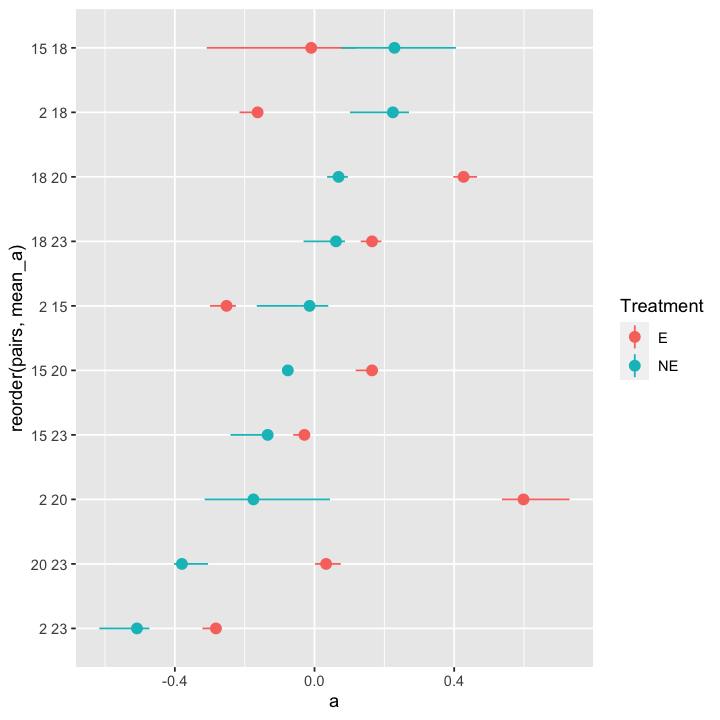

In [14]:
pairs_means <- feas_df %>% 
    filter(Treatment == "NE") %>%
    group_by(pairs, Treatment) %>%
    summarise(mean_a = mean(a)) %>%
    select(pairs,mean_a)


feas_df %>%
    left_join(pairs_means) %>%
    ggplot(aes(x=a,y=reorder(pairs,mean_a),group = Treatment, color = Treatment))+
          stat_summary(fun = mean, fun.min = function(z) { quantile(z,0.05) },
               fun.max = function(z) { quantile(z,0.95) })

New names:
* `` -> ...1



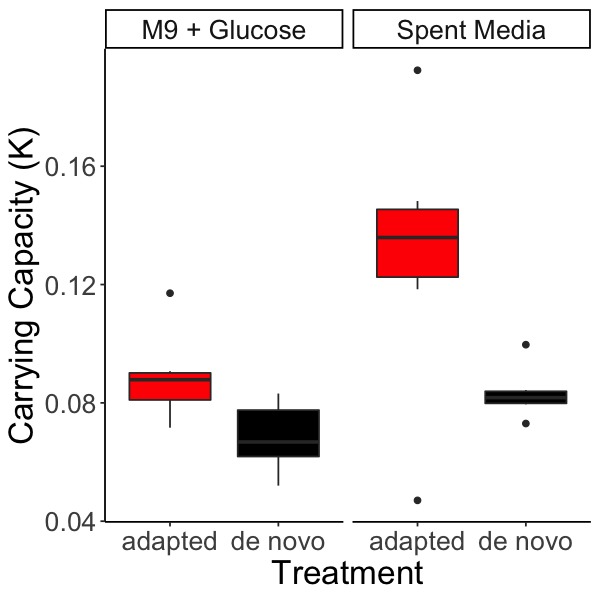

In [15]:
options(repr.plot.width = 5, repr.plot.height = 5)
p1 = read_csv("../data/interactions/Com_LogisticIndivcurves.csv", col_types = cols()) %>%
    separate(pa,into=c("a","Rep"),sep = ":") %>%
    separate(a, into = c("Treatment","Media"), sep = "-") %>%
    mutate(Media = ifelse(Media == "M9", "M9 + Glucose", "Spent Media")) %>%
    mutate(Treatment = recode(Treatment,"CE" = "adapted", "CN" = "de novo")) %>%
    ggplot(aes(x=(Treatment), y = K, fill = Treatment))+
        geom_boxplot()+
        facet_wrap(~Media)+
        xlab("Treatment")+
        ylab("Carrying Capacity (K)") +
        theme_classic()+
        theme(legend.position = "none", text = element_text(size = 20)) +
        scale_fill_manual(values = c("adapted"="Red","de novo"="Black"),label = c("co-evolved","de novo"))

p1

In [29]:
plot_int <- plot_grid(p1,p2, labels = c("a","b"), rel_widths = c(0.6,0.4),label_size = 20)

ggsave("..//plots/Fig3_interactions_new.pdf", plot_int, height = 5, width = 10)

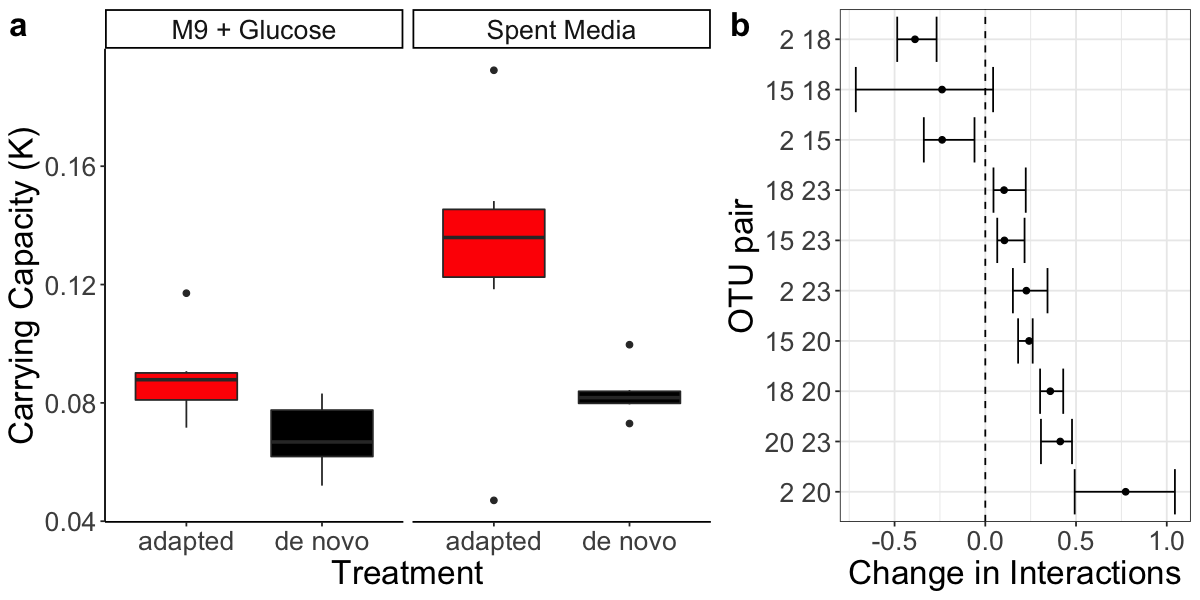

In [30]:
options(repr.plot.width = 10, repr.plot.height = 5)

plot_int 

In [24]:
feas_df %>%
    group_by(Treatment) %>%
    summarise(mean = mean(a) , sd = sd(a))

Treatment,mean,sd
<chr>,<dbl>,<dbl>
E,0.06524750,0.2767387
NE,-0.07042543,0.2384004


In [25]:
#a vs ER

a_df <- feas_df %>%
    group_by(OTU_1,OTU_2,Treatment) %>%
    summarise(a = mean(a))

a_df <- a_df %>%
    mutate(OTU_1_ = OTU_1) %>%
    mutate(OTU_1 = OTU_2, OTU_2 = OTU_1) %>%
    select(-OTU_1_) %>%
    bind_rows(a_df)


ER_df <- read_csv("..//data//Resp_E_ind.csv", show_col_types = FALSE) %>%
    mutate(Treatment = case_when(Treatment == "Nonevolved" ~ "NE",
                                 Treatment == "evolved" ~ "E")) %>%
    mutate(OTU_1 = as.character(as.numeric(str_replace(Sps, "R_","")))) %>%
    select(OTU_1,Treatment, Ea) %>%
    right_join(a_df)

p_ERvsa <- ER_df %>%
    mutate(Treatment = case_when(Treatment == "NE" ~ "de novo",
                                 Treatment == "E" ~ "assembled")) %>%
    ggplot(aes(x= Ea, y = a))+
        geom_point()+
        facet_grid(~Treatment)+
        theme_classic()+
        ylab("Interaction Estimates")+
        xlab(expression(paste("Population Sensitvity", bgroup("(",E[R],")") )))

ggsave("../plots/FigS6_Evsa.pdf", p_ERvsa, width = 5, height = 3)

`summarise()` has grouped output by 'OTU_1', 'OTU_2'. You can override using the `.groups` argument.

New names:
* `` -> ...1

Joining, by = c("OTU_1", "Treatment")



In [26]:
NE_df <- ER_df %>% filter(Treatment == "NE") 
cor.test(~ a + Ea, data = NE_df)


	Pearson's product-moment correlation

data:  a and Ea
t = -0.64662, df = 18, p-value = 0.526
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.5561114  0.3127010
sample estimates:
       cor 
-0.1506689 


In [27]:
NE_df <- ER_df %>% filter(Treatment == "E") 
cor.test(~ a + Ea, data = NE_df)


	Pearson's product-moment correlation

data:  a and Ea
t = 0.52398, df = 18, p-value = 0.6067
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.3382982  0.5360189
sample estimates:
      cor 
0.1225722 
